<a href="https://colab.research.google.com/github/ykato27/GAN/blob/main/02_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks (GAN)
## 目的
GANによって画像の生成をして動作を理解する．

## 必要なモジュールのインポート
Pytorchで学習するときに必要となるモジュールをインポートします．

In [1]:
import os
import zipfile
import urllib.request
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

## ネットワークの構築
GANは，Generator (生成器)とDiscriminator (識別器)と呼ばれる２つのネットワークによって構成されている生成モデルです．
そのため，2つのネットワークを別々に構築します． <br>
Generatorは，$N(0, 1)$や$U[-1, 1]$からサンプリングした潜在変数を入力して画像を生成するネットワークです．Generatorは，綺麗な画像を生成することでDiscriminatorを欺くことを目的としています．<br>
一方で，Discriminatorは実画像 (訓練画像)またはGeneratorが生成した画像のどちらかを入力して，入力されたデータを正確に判別するネットワークです．Discriminatorは，入力画像の中からGeneratorの生成した画像を見破ることを目的としています．<br>
GANの学習は，一般的な事象に置き換えて，しばしば，「偽札製造者と警察官」を例に出して説明することがあります．この場合Generatorが偽札製造者でDiscriminatorが警察官です．<br>
GANのネットワークを簡易的に表現したものを，以下に示します．<br>
<img src="https://dl.dropboxusercontent.com/s/deek34es6dqu4lb/gan.png" width=50%>

GANの最終的な目的は，実画像$x$の確率分布$p_{data}(x)$と実画像$x$をGenerator上の分布で見た時の確率分布$p_{g}(x)$が一致することです．つまり，$p_{data}(x)=p_{g}(x)$が成立した時にDiscriminatorが完全にRealなのかFakeなのかわからなくなっていると言えます．<br>
Generator及びDiscriminatorの構造は非常にシンプルで，全結合とReLUによって構築します．

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 784))
        
    def forward(self, z):
        return self.layer(z)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1))
    
    def forward(self, x):
        return self.layer(x)

## データセットと最適化関数
データセットにはMNISTを使用します．
最適化関数はAdam optimizer使用し，学習率$2\times 10^4$，betaの値を$0.5, 0.999$として学習します．

In [3]:
class MNIST_Loader(Dataset):
  def __init__(self, train=True, download=True, transform=None):
    self.transform = transform
    self.url = 'https://www.dropbox.com/s/hc7ukm7vzst5e40/MNIST.zip?dl=1'
    
    if download:
      self._download()
    
    dname = os.path.join(self.url.rpartition('/')[2][:-9], 'processed')
    if train:
      datapath = os.path.join(dname, 'training.pt')
    else:
      datapath = os.path.join(dname, 'test.pt')
  
    self.data = torch.load(datapath)

  def __len__(self):
    return len(self.data[0])

  def _download(self):
    filename = self.url.rpartition('/')[2][:-5]
    urllib.request.urlretrieve(self.url, filename)

    with zipfile.ZipFile(filename) as existing_zip:
      existing_zip.extractall()
    os.remove(filename)

  def __getitem__(self, i):
    image = transforms.ToPILImage()(self.data[0][i])
    label = self.data[1][i]

    if self.transform:
      image = self.transform(image)
    return image, label

In [4]:
transform_train = transforms.Compose([transforms.ToTensor()])
try:
  mnist_data = datasets.MNIST(root='./data', train=True, transform=transform_train, download=True)
except:
  print('Warning: Switch the original implementation because official MNIST data did not download (probably the official server has down).')
  mnist_data = MNIST_Loader(train=True, download=True, transform=transform_train)
print('Done!') 
training_data = DataLoader(mnist_data, batch_size=100, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_dim = 100
G = Generator(latent_dim=latent_dim).to(device)
D = Discriminator().to(device)
opt_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## GANの学習
ここでは，Generator及びDiscriminatorを用いてGANの学習をします．<br>
GANの最適化式は以下に示すとおりです．
$$
\min_{G}\max_{D}V(D, G) = \mathbb{E}_{x\sim P_{data}(x)}\left[\log\left(D(x)\right)\right] + \mathbb{E}_{z\sim P(z)}\left[\log\left(1 - D(\hat{x})\right)\right]
$$
ここで，$x$は実画像で$\hat{x}$がGeneratorの生成した画像G(z)に対応します．<br>
GANを学習する際は，binary cross entopyを用いて，実画像は1に，生成画像は0に近似するように学習をします．
Discriminatorは，実画像は1生成画像は0と識別するとように学習をしますが，Generatorは生成した画像を実画像であるとDiscriminatorに誤識別をさせたいので，1と識別されるように学習をします．

これによりGANの醍醐味である敵対学習を完成させることができます．<br>
ここで，n_epochは学習回数です．n_criticはdiscriminatorを1 iterationで何回更新するかの数となっています．<br>
Discriminatorを複数回更新した後にGeneratorを1回更新する理由は，モード崩壊を防止するためです．モード崩壊とは，GANの学習では深刻な問題で，Generatorがある一定の画像しか生成できなることや全く画像が生成できなくなることを指します．<br>
Discriminatorは，おバカすぎてもダメで，賢すぎてもダメなのでいい塩梅をn_criticで指定しましょう．n_criticが多いと簡単にモード崩壊します．　（理想は2回ぐらいだと思います．）

In [5]:
n_epoch = 10
n_critic = 2
criterion = nn.BCEWithLogitsLoss()

for epoch in range(1, n_epoch+1):
    Tensor = torch.cuda.FloatTensor
    for idx, (real_x, _) in enumerate(training_data):
        real_x = real_x.cuda()
        batch = real_x.size(0)
        flag_real = Tensor(batch, 1).fill_(1.0)
        flag_fake = Tensor(batch, 1).fill_(0.0)
        
        for _ in range(n_critic):
            D.zero_grad()
            z = torch.randn(batch, latent_dim).to(device)
            fake_x = G(z)
            out_real = D(real_x.view(batch, -1))
            out_fake = D(fake_x.detach().view(batch, -1))
            loss_real = criterion(out_real, flag_real)
            loss_fake = criterion(out_fake, flag_fake)
            dis_loss = loss_real + loss_fake
            dis_loss.backward()
            opt_d.step()
            
        G.zero_grad()
        z = torch.randn(batch, latent_dim).to(device)
        fake_x = G(z)
        out_gen = D(fake_x)
        gen_loss = criterion(out_gen, flag_real)
        gen_loss.backward()
        opt_g.step()
        
        if idx % 100 == 0:
            print('Training epoch: {} [{}/{} ({:.0f}%)] | D loss: {:.6f} | G loss: {:.6f} |'\
                  .format(epoch, idx * len(real_x), len(training_data.dataset),
                  100. * idx / len(training_data), dis_loss.item(), gen_loss.item()))

Training epoch: 1 [0/60000 (0%)] | D loss: 1.372854 | G loss: 0.716239 |
Training epoch: 1 [10000/60000 (17%)] | D loss: 0.187632 | G loss: 2.344921 |
Training epoch: 1 [20000/60000 (33%)] | D loss: 0.019561 | G loss: 4.466909 |
Training epoch: 1 [30000/60000 (50%)] | D loss: 0.088888 | G loss: 5.301004 |
Training epoch: 1 [40000/60000 (67%)] | D loss: 0.166391 | G loss: 6.683227 |
Training epoch: 1 [50000/60000 (83%)] | D loss: 0.146077 | G loss: 6.569215 |
Training epoch: 2 [0/60000 (0%)] | D loss: 0.127525 | G loss: 4.937968 |
Training epoch: 2 [10000/60000 (17%)] | D loss: 0.075734 | G loss: 5.088417 |
Training epoch: 2 [20000/60000 (33%)] | D loss: 0.088859 | G loss: 4.956818 |
Training epoch: 2 [30000/60000 (50%)] | D loss: 0.040815 | G loss: 5.471310 |
Training epoch: 2 [40000/60000 (67%)] | D loss: 0.035646 | G loss: 5.999030 |
Training epoch: 2 [50000/60000 (83%)] | D loss: 0.109470 | G loss: 3.776830 |
Training epoch: 3 [0/60000 (0%)] | D loss: 0.078768 | G loss: 4.862548 |
T

## 学習したGeneratorによる画像生成

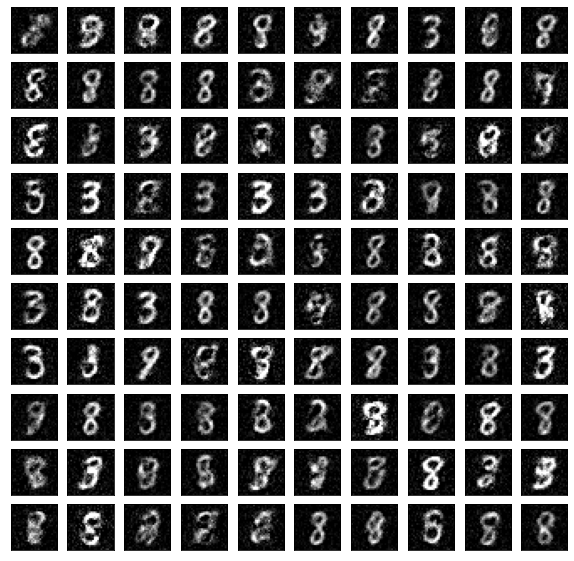

In [6]:
num_generate = 100
ch = 100
z = torch.randn(num_generate, ch).to(device)
test_img = G(z)
test_img_array = (test_img * 256.).clamp(min=0., max=255.).view(num_generate, 28, 28).data.cpu().numpy()

fig = plt.figure(figsize=(10, 10))
for i, im in enumerate(test_img_array):
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

# 参考文献
[1] Ian Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville and Yoshua Bengio, Generative adversarial nets, NIPS, 2014.